In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
from astropy.table import QTable, Column
import astropy.units as u
from scipy.optimize import minimize
import numpy.ma as ma

In [2]:
# Physical Constants
c = 3E5 # km * s ^1
h = 1 # reduced hubble constant
H_0 =  100 * h # km * s^-1 * Mpc^-1

In [3]:
# from GalaxyFitting import likelihood_function
from rotation_curve_functions import vel_b,disk_vel,vel_h_iso, vel_h_NFW, vel_h_Burket,vel_co_iso, vel_co_iso_nb, vel_co_NFW, vel_co_NFW_nb, vel_co_Burket, vel_co_Burket_nb
from Velocity_Map_Functions import rot_incl_iso, rot_incl_iso_nb, rot_incl_NFW, rot_incl_NFW_nb, rot_incl_bur, rot_incl_bur_nb, nloglikelihood_iso, nloglikelihood_iso_nb, nloglikelihood_bur_nb

# Obtain physical data for 7443-12705

In [4]:
# Used files
DTable1 = QTable.read('Master_Table.txt',format='ascii.commented_header')
DTable2 = QTable.read('DRPall-master_file.txt',format='ascii.ecsv')
# Get the Mass of stars & redshifts & angular resolution of r50
m = DTable1['NSA_Mstar'].data
rat = DTable1['NSA_ba'].data
phi = DTable1['NSA_phi'].data
z = DTable2['redshift'].data
r50_ang = DTable2['nsa_elpetro_th50_r'].data

In [5]:
# Obtain the effective radius for plate IFU 7443-12705
r50_spec = 0
z_spec = 0
for i in range(len(DTable2)):
    if DTable2['MaNGA_plate'][i] == 7443 and DTable2['MaNGA_IFU'][i] == 12705:
        r50_spec = r50_ang[i]
        z_spec = z[i]

# Obtain stellar mass of 7443-12705
m_spec = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        m_spec = m[i]
print(np.log10(m_spec))

# Obtain inclination
incl = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        incl = np.arccos(rat[i])
print(incl)

# Obtain phi
ph = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        ph = phi[i]*np.pi/180
print(ph)

#  Calculate the recession velocity for 7443-12705
v_rec = z_spec * c # km/s

# Using Hubble's Law to calculate distance [kpc] for 7443-12705
d = v_rec/H_0 # Mpc
d *= 1E3 # kpc

# Using Small Angle Formula to calculate the actual value of r50 [kpc] for 7443-12705
theta = r50_spec/206265 # radian
r50 = theta * d # kpc
print(r50)
print(z_spec)
print(d)
scale_spec = 0.5*(193420.5)/206265
print(scale_spec)

10.353951647911828
1.2005955251079776
0.6421872084106552
6.912622583739364
0.0644735
193420.5
0.46886408261217366


# Obtain velocity map data 7443-12705

In [6]:
cube = fits.open('manga-7443-12705-MAPS-HYB10-GAU-MILESHC.fits.gz')

r_band = cube['SPX_MFLUX'].data
Ha_vel = cube['EMLINE_GVEL'].data[18]
Ha_vel_ivar = cube['EMLINE_GVEL_IVAR'].data[18]
Ha_vel_mask = cube['EMLINE_GVEL_MASK'].data[18]

cube.close()

v_masked = ma.array(Ha_vel,mask=Ha_vel_mask)

# Model Generation 

Using current functions from "velocity_map_functions.py"

/gpfs/fs1/home/yzh250/rotation_curve_functions.py:208: RuntimeWarning: invalid value encountered in double_scalars
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
/gpfs/fs1/home/yzh250/rotation_curve_functions.py:425: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(G * halo_mass_kg / (r * 3.0857E16))


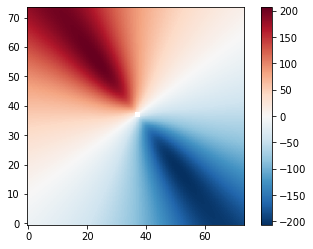

In [7]:
gal_shape = [74,74]
# Initial guesses for minimize
params = [1000,4,0.006,25,incl,ph,37,37]
model = rot_incl_bur_nb(gal_shape,scale_spec,params)
plt.imshow(model,origin='lower',cmap='RdBu_r')
plt.colorbar()

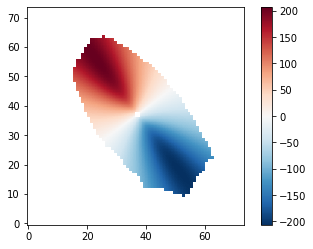

In [8]:
model_mask = ma.array(model, mask = Ha_vel_mask)
plt.imshow(model_mask,origin='lower',cmap='RdBu_r')
plt.colorbar()

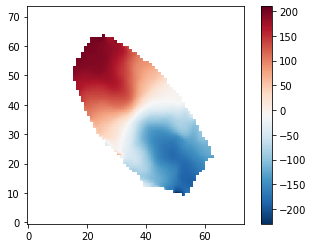

In [9]:
plt.imshow(v_masked,origin='lower',cmap='RdBu_r')
plt.colorbar()

Pick a random point on both maps

In [10]:
# Data map
v_masked[50][30]

161.27083

In [11]:
# Model map
model_mask[50][30]

184.52883711423007

They are reasonably close (in the right order of magnitude)

# Math Check
This checked will be used to modify the functions in the file "velocity_map_functions.py"

In [12]:
x = -1
y = 1
phi = np.pi/4

In [13]:
x_rot = np.sin(np.pi/4)*x + np.cos(np.pi/4)*y
y_rot = -np.cos(np.pi/4)*x + np.sin(np.pi/4)*y
x_rot

1.1102230246251565e-16

In [14]:
y_rot

1.414213562373095

This gives result

$(x',y') = (0,1.414)$

But this rotation matrix above gives a clockwise rotation.

\begin{bmatrix}
cos(\phi) & sin(\phi)\\
-sin(\phi) & cos(\phi) \\
\end{bmatrix}

The rotation matrix below will have counter-clockwise rotation.

\begin{bmatrix}
cos(\phi) & -sin(\phi)\\
sin(\phi) & cos(\phi) \\
\end{bmatrix}


In [15]:
def incl_bur_nb(shape,scale,params):
    SigD,r_d,rho_h,r_h,inclination,phi,center_x,center_y = params
    rotated_inclined_map = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            x = (i - center_x)/np.cos(inclination)
            y = (j - center_y)
            r = np.sqrt(x**2+y**2)
            theta = np.arctan2(x,y)
            r_in_kpc = r*scale
            v = vel_co_Burket_nb(r_in_kpc,[SigD,r_d,rho_h,r_h])*np.sin(inclination)*np.cos(theta)
            rotated_inclined_map[i,j] = v
    return rotated_inclined_map

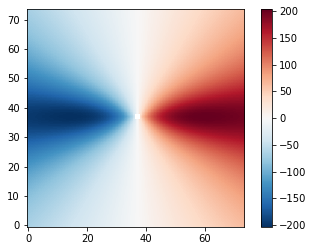

In [16]:
plt.imshow(incl_bur_nb(gal_shape,scale_spec,[1000,4,0.005,25,incl,ph,37,37]),origin='lower',cmap='RdBu_r')
plt.colorbar()

We see that the positive velocity is on the x-axis not the y axis.

In [17]:
# New model function
def RI_bur_nb(shape,scale,params):
    SigD,r_d,rho_h,r_h,inclination,phi,center_x,center_y = params
    rotated_inclined_map = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            xb = ((i-center_x)*np.cos(np.pi/2) - np.sin(np.pi/2)*(j-center_y))
            yb = ((i-center_x)*np.sin(np.pi/2) + np.cos(np.pi/2)*(j-center_y))
            x = (xb*np.cos(phi) - yb*np.sin(phi))/np.cos(inclination)
            y = (xb*np.sin(phi) + yb*np.cos(phi))
            r = np.sqrt(x**2+y**2)
            theta = np.arctan2(x,y)
            r_in_kpc = r*scale
            v = vel_co_Burket_nb(r_in_kpc,[SigD,r_d,rho_h,r_h])*np.sin(inclination)*np.cos(theta)
            rotated_inclined_map[i,j] = v
    return rotated_inclined_map

Setting $\phi = 0$ 

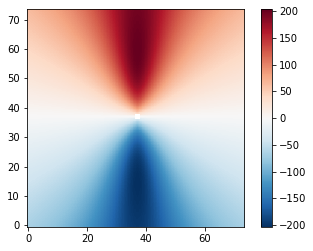

In [18]:
model_n = RI_bur_nb(gal_shape,scale_spec,[1000,4,0.005,25,incl,0,37,37])
plt.imshow(model_n,origin='lower',cmap='RdBu_r')
plt.colorbar()

Now the positive velocity is on the y-axis even when $\phi = 0$

Testing the model again.

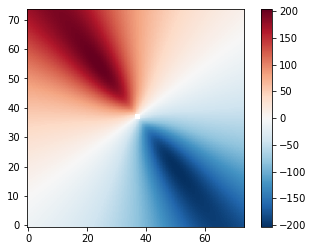

In [19]:
plt.imshow(RI_bur_nb(gal_shape,scale_spec,[1000,4,0.005,25,incl,ph,37,37]),origin='lower',cmap='RdBu_r')
plt.colorbar()

# Now try minimize

In [ ]:
# Initial guesses
param_bounds_bur_nb = [[500, 3000],  # Disk mass [log(Msun)]
                [0.1, 20],  # Disk radius [kpc]
                [50, 500],  # Velocity at infinity [km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [-np.pi/2,np.pi/2],# Phase angle
                [0.1,40],#center_x
                [0.1,40]] #center_y
p0_bur_nb = [1000, 4, 150, 15, incl,ph,37,37]
bestfit_bur_nb = minimize(nloglikelihood_bur_nb, p0_bur_nb, args=(scale_spec, gal_shape, v_masked, Ha_vel_ivar),bounds=param_bounds_bur_nb)
print('---------------------------------------------------')
print(bestfit_bur_nb)
# Plotting
model_map_bur_nb = rot_incl_bur_nb(gal_shape,scale_spec,bestfit_bur_nb.x)
mask_model_map_bur_nb = ma.array(model_map_bur_nb,mask=Ha_vel_mask)
plt.imshow(mask_model_map_bur_nb,origin='lower',cmap='RdBu_r')
plt.colorbar()